In [1]:
import json
import re
from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import quandl
import functools
import plotly.express as px
import plotly.graph_objects as go
from src.ubacktester import (
    BacktestEngine, StrategyBase, PositionBase, FeedBase,
    PlotlyPlotter, FeedID, PriceFeed
)

%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

# 20230119_hw2_ho_ethan_12350006

@mpcs
@finm33550

Ethan Ho 1/14/2023

----

The last digit of my student ID is 6, so I'll be analyzing the following ETF pair: `X: HYLD` and `Y: JNK`

## Configuration & Helper Functions

The following cell contains helper functions and configuration options that I will use in this notebook.

In [2]:
def get_secrets(fp='./secrets.json'):
    """
    Reads secret values such as API keys from a JSON-formatted file at `fp`.
    """
    with open(fp, 'r') as f:
        data = json.load(f)
    return data

def get_quandl_api_key() -> str:
    """
    Returns Quandl API key stored in secrets.json.
    """
    secrets = get_secrets()
    key = secrets.get('NASTAQ_DATA_API_KEY')
    assert key, f"NASTAQ_DATA_API_KEY field in secrets.json is empty or does not exist"
    return key

@functools.lru_cache(maxsize=1600)
def fetch_quandl_quotemedia_prices(
    start_date, end_date, ticker
) -> pd.DataFrame:
    df = quandl.get_table(
        'QUOTEMEDIA/PRICES',
        date={'gte': start_date, 'lte': end_date},
        ticker=ticker,
        api_key=get_quandl_api_key(),
    )
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

# Fetch Data and Calculate $N_t$

Let's check that our data-fetching function works as expected for our first ETF:

In [3]:
hyld = fetch_quandl_quotemedia_prices('2020-12-02', '2022-11-15', 'HYLD')
hyld.head()

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2020-12-02,HYLD,31.5800,31.7933,31.3100,31.5650,"312,393.0000",0.0000,1.0000,28.0843,28.2739,27.8441,28.0709,"312,393.0000"
2020-12-03,HYLD,31.7400,31.8430,31.6100,31.7000,"9,173.0000",0.0000,1.0000,28.2265,28.3181,28.1109,28.1910,"9,173.0000"
2020-12-04,HYLD,31.7547,31.9200,31.7300,31.8727,"12,848.0000",0.0000,1.0000,28.2396,28.3866,28.2177,28.3446,"12,848.0000"
2020-12-07,HYLD,31.9400,31.9400,31.7200,31.9300,"22,507.0000",0.0000,1.0000,28.4044,28.4044,28.2088,28.3955,"22,507.0000"
2020-12-08,HYLD,31.9500,31.9500,31.8400,31.9100,"13,878.0000",0.0000,1.0000,28.4133,28.4133,28.3155,28.3777,"13,878.0000"


Next, we'll estimate the daily dollar volume. We were told to multiply closing price by volume (shares) to estimate this, but I want to be a little more accurate by using the midprice.

In [4]:
hyld['adj_mid'] = hyld[['adj_open', 'adj_close']].mean(axis=1)
hyld[['adj_open', 'adj_mid', 'adj_close']].head()

,adj_open,adj_mid,adj_close
date,,,
2020-12-02,28.0843,28.0776,28.0709
2020-12-03,28.2265,28.2088,28.1910
2020-12-04,28.2396,28.2921,28.3446
2020-12-07,28.4044,28.4000,28.3955
2020-12-08,28.4133,28.3955,28.3777


In [5]:
hyld['vol_usd'] = hyld['adj_volume'] * hyld['adj_mid']
hyld['vol_usd'].head()

date
2020-12-02   8,771,241.9298
2020-12-03     258,758.9597
2020-12-04     363,496.7511
2020-12-07     639,197.9238
2020-12-08     394,072.9509
Name: vol_usd, dtype: float64

Next, we compute the running 15-trading-day median of this daily dollar volume:

In [6]:
hyld['vol_usd_15'] = hyld['vol_usd'].rolling(window=15).median()
hyld['vol_usd_15'].describe()

count       479.0000
mean    436,502.4149
std     184,633.5457
min     117,993.0700
25%     288,010.6464
50%     462,693.9820
75%     579,548.6447
max     904,944.1815
Name: vol_usd_15, dtype: float64

We now repeat this process for ETF `Y` to determine which is less liquid:

In [7]:
jnk = fetch_quandl_quotemedia_prices('2020-12-02', '2022-11-15', 'JNK')

jnk['adj_mid'] = jnk[['adj_open', 'adj_close']].mean(axis=1)
jnk[['adj_open', 'adj_mid', 'adj_close']].head()

jnk['vol_usd'] = jnk['adj_volume'] * jnk['adj_mid']

jnk['vol_usd_15'] = jnk['vol_usd'].rolling(window=15).median()
jnk['vol_usd_15'].describe()

count             479.0000
mean      885,719,325.6924
std       216,329,273.0451
min       547,291,550.7352
25%       726,872,221.4972
50%       857,668,758.8120
75%     1,011,418,102.7873
max     1,548,416,218.7625
Name: vol_usd_15, dtype: float64

It appears that overall, JNK is a more liquid market than HYLD.

Let's check this formally. The below mask will return True if the JNK 15-day median is _always_ greater than the HYLD median:

In [8]:
(
    # if JNK volume > HYLD volume
    (jnk['vol_usd_15'] > hyld['vol_usd_15'])
    # or volume is null due to rolling()
    | jnk['vol_usd_15'].isnull()
).all()

True

As we suspected, JNK is always more liquid in this window for this timeframe. We could safely use only HYLD values for $N_t$, but regardless of this, let's calculate $N_t$ explicitly.

First, we assemble the 15-day median into a new DataFrame:

In [9]:
etf_vol = pd.concat([jnk['vol_usd_15'], hyld['vol_usd_15']], keys=['jnk', 'hyld'], axis=1)
etf_vol.tail()

,jnk,hyld
date,,
2022-11-09,"1,006,327,150.4100","168,832.3005"
2022-11-10,"1,010,398,234.4200","168,832.3005"
2022-11-11,"1,010,398,234.4200","159,257.4000"
2022-11-14,"1,010,398,234.4200","168,832.3005"
2022-11-15,"1,045,125,541.8050","169,571.7000"


Then calculate $N_t$ as the minimum of the two columns for each row:

In [10]:
n_t = etf_vol.min(axis=1)
n_t.tail()

date
2022-11-09   168,832.3005
2022-11-10   168,832.3005
2022-11-11   159,257.4000
2022-11-14   168,832.3005
2022-11-15   169,571.7000
dtype: float64

TODO: Fama-French factors

# Define Spread-Reversion Strategy

The next part of this homework deals with coding and backtesting a spread-reversion strategy for this ETF pair.

I took the time to write my own backtesting framework from scratch, which I've named uBacktester (micro-backtester). It uses only the dependencies that are considered "standard" for this course; the only dependencies that are not in the standard library are pandas, numpy, and plotly. The entirety of the backtesting framework is defined in the source code file `src/ubacktester.py`, which is included in the `.zip` archive with this notebook. Its design is loosely inspired by the [backtrader](https://github.com/mementum/backtrader) project.

uBacktester is fairly well documented with docstrings and inline comments, so please refer to the docs in that file for implementation details. In short, it provides a set of wrapper classes around pandas DataFrames that allows one to interact with positions, strategies, and data feeds as [Python dataclasses](https://docs.python.org/3/library/dataclasses.html). Customization is conferred through subclassing the base classes for positions, strategies, and data feeds.

The homework prompt specifies that this spread-reversion strategy should:

- Begin on first day of each month
- Close all open positions at the end of the month
- Trade using EOD prices
- Trade equal-sized dollar amounts of `X` and `Y` as close as possible to $\$N_t/100$ each
- Trade integer number of shares
- Track $\$2N_t/100$ for any open position
- Enters position if $z > g$
- Exits the position if $z < j$ with $j<g$
- Holds at most one spread position at a time
- Does not adjust position size based on $N_t$.

Below, I define this strategy as a subclass of StrategyBase.
First, however, we'll construct a data feed of adjusted closing prices and $N_t$, which our strategy will have access to during the backtest simulation.

In [11]:
feed0_df = pd.concat([
    jnk['adj_close'],
    hyld['adj_close'],
    n_t
], keys=['jnk', 'hyld', 'n_t'], axis=1)
feed0_df.head()

,jnk,hyld,n_t
date,,,
2020-12-02,99.8673,28.0709,NaN
2020-12-03,99.9322,28.1910,NaN
2020-12-04,100.3492,28.3446,NaN
2020-12-07,100.2843,28.3955,NaN
2020-12-08,100.2843,28.3777,NaN


We can now define our spread-reversion strategy:

In [12]:
@dataclass
class ETFSpreadRevStrat(StrategyBase):
    M: int = 15
    # We'll save the price of the spread as a dataclass
    # attribute so that we can track it over time.
    spread: float = 0.
    
    def is_eom(self) -> bool:
        """
        Determines if current datetime `self.dt` is at
        the end of the month.
        """
        return (
            pd.to_datetime(self.dt) == pd.to_datetime(self.dt)
            + pd.tseries.offsets.MonthEnd(0)
        )
    
    def get_pos_size(self) -> float:
        """Get the position size for each leg of the spread."""
        n_t = self.feeds['price'].n_t
        if pd.isnull(n_t):
            return 0.
        else:
            return n_t / 100.
    
    def get_n_shares(self, symbol: str) -> int:
        """Get integer number of shares of `symbol` to buy."""
        price = getattr(self.feeds['price'], symbol)
        pos_size = self.get_pos_size()
        return round(pos_size / price)
    
    def step(self):
        """
        This function is called once for every step in the simulation,
        which in our case is once a day.
        """
        feed = self.feeds['price'] # shortcut for price feed
        
        # Close all positions if we're at end of month
        if self.is_eom():
            if self.npositions:
                print(f"{self.dt.date()} is at end of month. "\
                      f"Exiting {self.npositions} positions...")
                self.exit_all()
            return
        
        # Calculate amount of each to buy in dollars ($N_t / 100)
        pos_size = self.get_pos_size()
        
        # We can index the feed to get the last M records
        # as a DataFrame
        last_m = feed[-self.M:]

        # Calculate M-day returns and the difference between
        # the two.
        jnk_returns = last_m['jnk'].iloc[-1] - last_m['jnk'].iloc[0]
        hyld_returns = last_m['hyld'].iloc[-1] - last_m['hyld'].iloc[0]
        self.spread = jnk_returns - hyld_returns

So far, we've created a strategy and compiled a DataFrame that it should have access to.
To run the simulation, we initialize a `BacktestEngine`, add our feed to the engine, add our strategy to the engine with some starting cash equity, and invoke the `run` method to begin simulation. This is a very similar API to many popular backtesting frameworks such as [backtrader](https://github.com/mementum/backtrader).

In [13]:
be = BacktestEngine(
    start_date='2020-12-02',
    end_date='2022-11-15',
    step_size='1D',
)
feed0 = PriceFeed.from_df(feed0_df)
be.add_feed(feed0, name='price')
spread_rev = ETFSpreadRevStrat(cash_equity=1e4)
be.add_strategy(spread_rev)
be.run()

I've coded much of the functionality of backtesting into uBacktester, so there is relatively little documentation in this notebook. For implementation and usage details, please inspect the docstring of the function or class, for example:

In [20]:
help(be.add_strategy)

Help on method add_strategy in module src.ubacktester:

add_strategy(strat: src.ubacktester.StrategyBase, name=None) method of src.ubacktester.BacktestEngine instance
    Add a strategy `strat` to the backtest. `strat.step()` will be called
    at every datetime `dt` value of the main clock.  Name is set
    from the strategy's `name` attribute, if `name` is not passed to this method.



Any subclass of `FeedBase` including `StrategyBase` and `PositionBase` has a convenient plotting method `plot`. Below are the usage docs and an example of plotting the price of our ETF spread using Plotly Express:

In [22]:
help(spread_rev._plot)

Help on method _plot in module src.ubacktester:

_plot(in_df: pandas.core.frame.DataFrame, date_col='dt', title=None, exclude_cols=('name',), only_numeric=True, include_cols=None, scale_cols: Dict[str, float] = None, height=600, width=800, labels: Optional[Dict] = None, names: Optional[Dict] = None, show: bool = False) method of __main__.ETFSpreadRevStrat instance
    Plot a pandas DataFrame `df` using Plotly Express, with x-axis
    range sliders.
    `date_col` can be used to override which column in `in_df`
    is used as the x-axis DateIndex ('dt' by default).
    Columns in `exclude_cols` will not be plotted.
    If `include_cols` is non-empty, only those columns will be plotted.
    `scale_cols` is a dictionary of string column names to floats, where
    the float is the scalar that will be applied to the value of the column
    before plotting.
    If `only_numeric` is True, will only plot columns in the DataFrame
    with a numeric data type.
    Passing `show=False` will not s

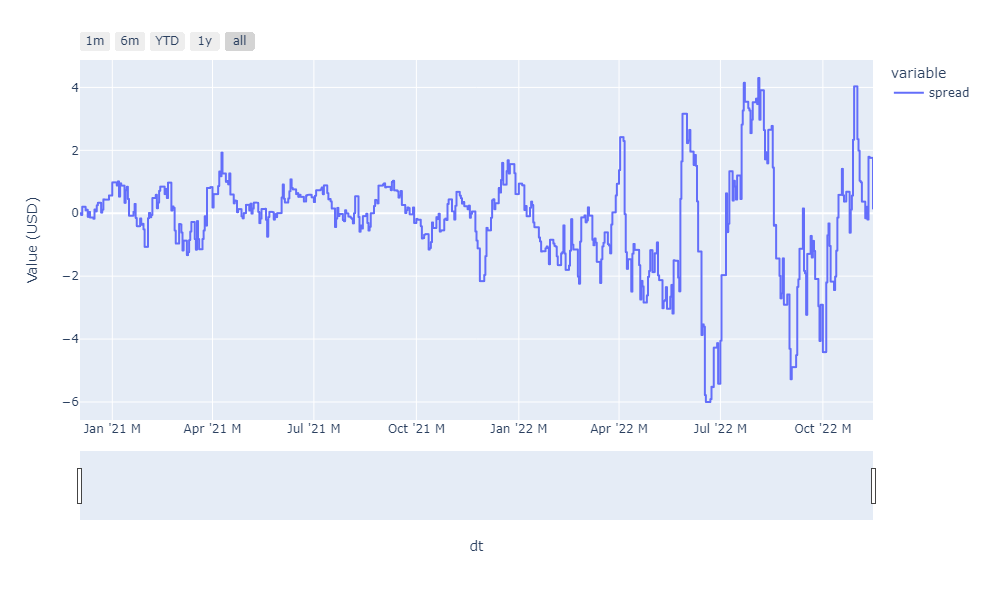

In [23]:
spread_rev.plot(
    labels={'value': 'Value (USD)'},
    include_cols=('spread',),
)

This ETF spread appears to mean revert. However, it is noticeably more volatile since January 2022. We could account for this in a future iteration of this strategy by normalizing the spread price, either by the sum of the assets' prices or by some measure of variance such as the sum of their $N$-day price ranges.

For now, let's just run the strategy as specified in the homework.